# dataloader test runs

## Parquet

In [5]:
import sys
sys.path.append("../modules")
from dataloader020 import load_parquet

# Specify your parquet file path
parquet_path = "/home/rc/version-cv/data/googleresearch/mathwriting/data/*.parquet"

# Example feature columns usage (optional)
feature_columns = ["latex", "split_tag", "sample_id"]
# If not specified, it will use all columns except target

target_column = "image"

# Run the loader
X_train, X_val, y_train, y_val, X_test = load_parquet(
    parquet_path=parquet_path,
    target_column=target_column,
    feature_columns=None,  
    test_size=0.2,
    val_size=0.1,
    random_state=42,
    verbose=True
)

# Print shapes to confirm
print("Train set:", X_train.shape, y_train.shape)
print("Val set:", X_val.shape, y_val.shape)
print("Test set:", X_test.shape)

Found 5 parquet files. Loading individually...
Final merged shape: (253182, 5)
Train shape: (177227, 4), Val shape: (50636, 4), Test shape: (25319, 4)
Train set: (177227, 4) (177227,)
Val set: (50636, 4) (50636,)
Test set: (25319, 4)


In [6]:
# Check train set
print("Columns in train set:", X_train.columns)
print("Example target values:", y_train.head())

Columns in train set: Index(['latex', 'sample_id', 'split_tag', 'data_type'], dtype='object')
Example target values: 251355    {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
212762    {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
45157     {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
20170     {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
144448    {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
Name: image, dtype: object


In [8]:
# Test run pass on mathwriting dataset from HF datasets
from dataloader020 import load_datasets_pipeline

# Call pipeline function
tf_train, tf_val, tf_test = load_datasets_pipeline(
    dataset_name="deepcopy/MathWriting-Human",
    tokenizer_name="gpt2",
    image_size=(224, 224),
    batch_size=32,
    shuffle=True,
    num_proc=4,      # Set num_proc (processes) based on your machine's cores (lower or higher)
    max_length=64,
    verbose=True
)

# Check data pipeline results 
print("TF Train dataset:", tf_train)
print("TF Val dataset:", tf_val)
print("TF Test dataset:", tf_test)

DatasetDict({
    train: Dataset({
        features: ['image', 'latex', 'sample_id', 'split_tag', 'data_type'],
        num_rows: 229864
    })
    test: Dataset({
        features: ['image', 'latex', 'sample_id', 'split_tag', 'data_type'],
        num_rows: 7644
    })
    val: Dataset({
        features: ['image', 'latex', 'sample_id', 'split_tag', 'data_type'],
        num_rows: 15674
    })
})


Map (num_proc=4):   0%|          | 0/229864 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/15674 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/7644 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/229864 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/15674 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/7644 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/229864 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/15674 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/7644 [00:00<?, ? examples/s]

/home/rc/version-cv/.pixi/envs/default/lib/python3.12/site-packages/datasets/arrow_dataset.py:400: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


TF Train dataset: <_PrefetchDataset element_spec=({'image': TensorSpec(shape=(None, 224, 224, 3), dtype=tf.int64, name=None), 'latex_ids': TensorSpec(shape=(None, 64), dtype=tf.int64, name=None)}, TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
TF Val dataset: <_PrefetchDataset element_spec=({'image': TensorSpec(shape=(None, 224, 224, 3), dtype=tf.int64, name=None), 'latex_ids': TensorSpec(shape=(None, 64), dtype=tf.int64, name=None)}, TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
TF Test dataset: <_PrefetchDataset element_spec=({'image': TensorSpec(shape=(None, 224, 224, 3), dtype=tf.int64, name=None), 'latex_ids': TensorSpec(shape=(None, 64), dtype=tf.int64, name=None)}, TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


In [11]:
for batch in tf_train.take(1):
    features, labels = batch  # Unpack tuple

    print("Feature keys:", features.keys())
    print("Images shape:", features["image"].shape)
    print("LaTeX IDs shape:", features["latex_ids"].shape)
    print("Labels shape:", labels.shape)

Feature keys: dict_keys(['image', 'latex_ids'])
Images shape: (32, 224, 224, 3)
LaTeX IDs shape: (32, 64)
Labels shape: (32,)


2025-07-12 23:29:34.249174: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


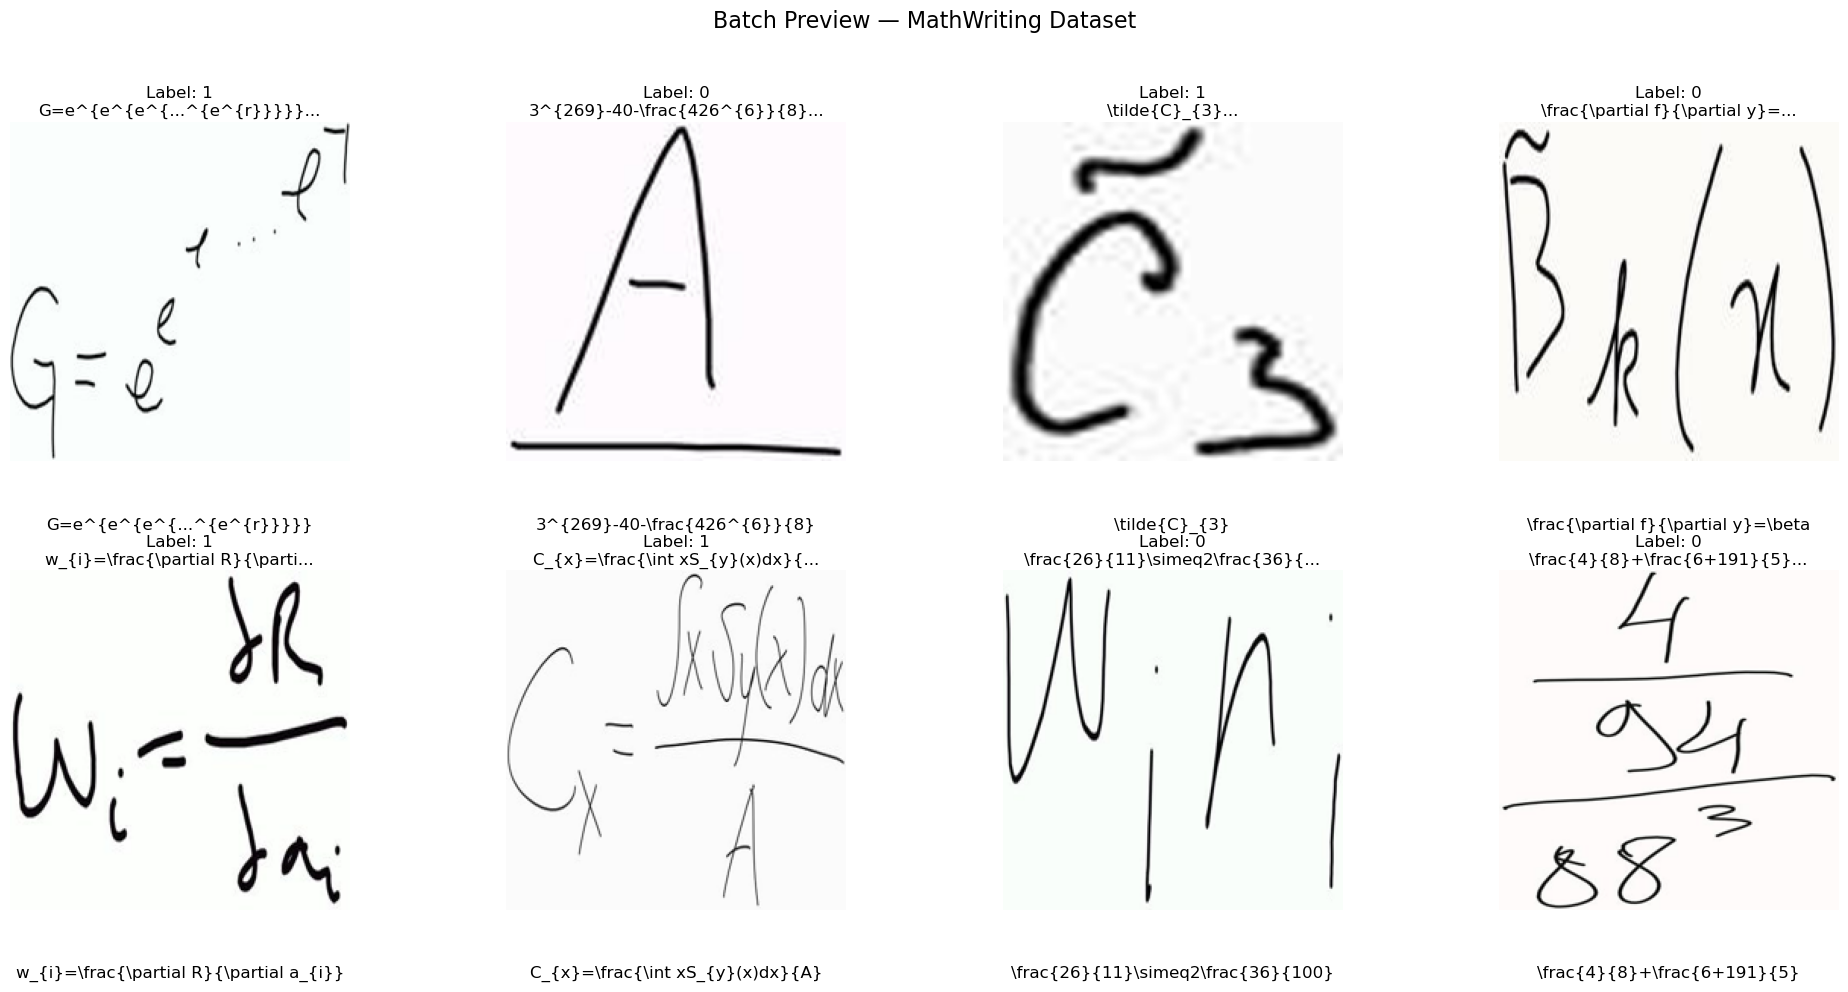

In [24]:
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
import numpy as np

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

for batch in tf_train.take(1):
    features, labels = batch

    images = features["image"].numpy()
    latex_ids_all = features["latex_ids"].numpy()

    # Fix image dtype and scale
    if images.max() > 1.0:
        images = np.clip(images, 0, 255).astype("uint8")
    else:
        images = (images * 255).astype("uint8")

    # Create figure
    plt.figure(figsize=(20, 10))

    for i in range(min(8, images.shape[0])):  # Show up to 8
        ax = plt.subplot(2, 4, i + 1)
        
        # If single-channel, convert to grayscale colormap
        if images[i].shape[-1] == 1 or np.all(images[i][..., 0] == images[i][..., -1]):
            plt.imshow(images[i].squeeze(), cmap="gray")
        else:
            plt.imshow(images[i])
        
        plt.axis("off")
        
        decoded_text = tokenizer.decode(latex_ids_all[i], skip_special_tokens=True).replace("\n", " ")
        ax.set_title(
            f"Label: {labels[i].numpy()}\n{decoded_text[:30]}...",
            fontsize=12,
            wrap=True
        )
        ax.text(
            0.5, -0.2,
            decoded_text[:50] + ("..." if len(decoded_text) > 50 else ""),
            fontsize=12,
            ha='center',
            wrap=True,
            transform=ax.transAxes
        )

    plt.suptitle("Batch Preview — MathWriting Dataset", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95]) 
    plt.show()
    break

In [ ]:
# dataloader test runs look good. still needs further refinement. but runs seamlessly at the time of build. 
# ASF technologies could scale this further to PB scale possibly. These are R&D builds not for production-grade.